In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# AVG DISTANCE

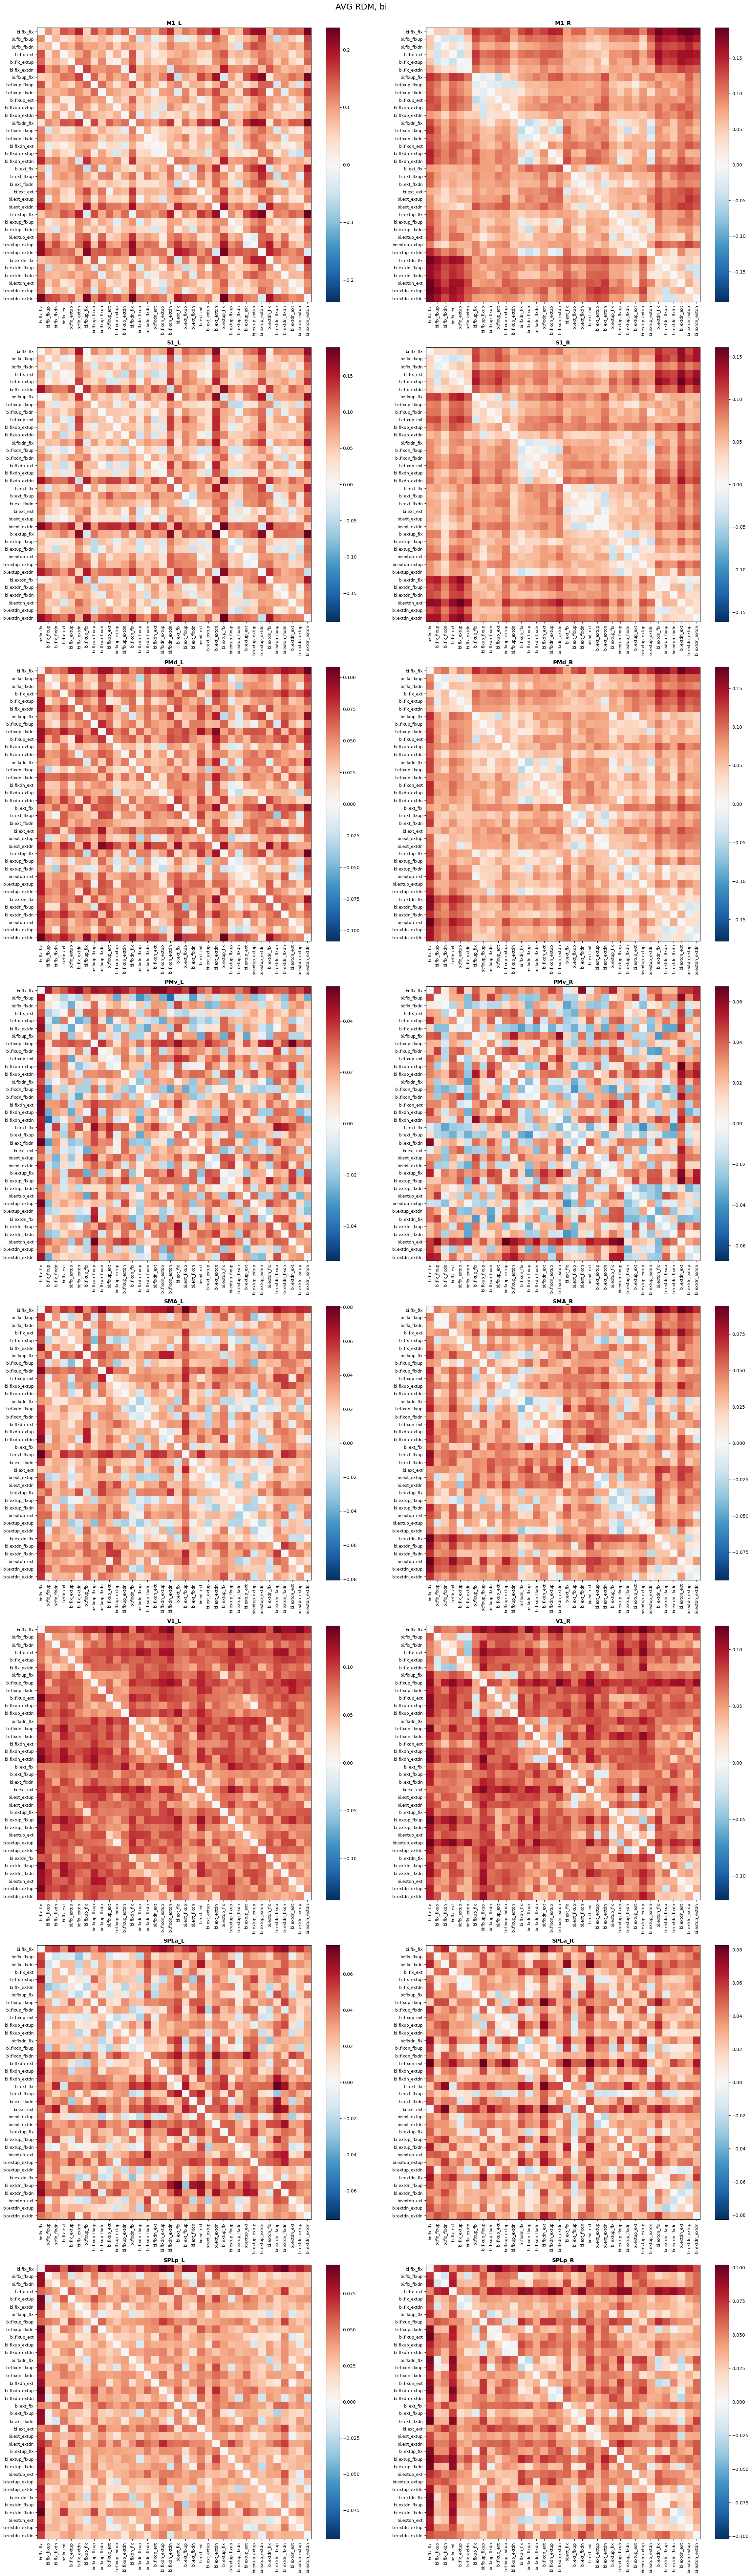

In [4]:
rois = [
    'M1_L', 'M1_R', 'S1_L', 'S1_R', 'PMd_L', 'PMd_R', 
    'PMv_L', 'PMv_R', 'SMA_L', 'SMA_R', 'V1_L', 'V1_R', 
    'SPLa_L', 'SPLa_R', 'SPLp_L', 'SPLp_R'
]
condition = 'bi'
labels = ['bi:flx_flx',    'bi:flx_flxup',   'bi:flx_flxdn',   'bi:flx_ext',   'bi:flx_extup',   'bi:flx_extdn',
          'bi:flxup_flx',  'bi:flxup_flxup', 'bi:flxup_flxdn', 'bi:flxup_ext', 'bi:flxup_extup', 'bi:flxup_extdn',
          'bi:flxdn_flx',  'bi:flxdn_flxup', 'bi:flxdn_flxdn', 'bi:flxdn_ext', 'bi:flxdn_extup', 'bi:flxdn_extdn',
          'bi:ext_flx',    'bi:ext_flxup',   'bi:ext_flxdn',   'bi:ext_ext',   'bi:ext_extup',   'bi:ext_extdn',
          'bi:extup_flx',  'bi:extup_flxup', 'bi:extup_flxdn', 'bi:extup_ext', 'bi:extup_extup', 'bi:extup_extdn',
          'bi:extdn_flx',  'bi:extdn_flxup', 'bi:extdn_flxdn', 'bi:extdn_ext', 'bi:extdn_extup', 'bi:extdn_extdn']
cmap = 'RdBu_r' 
sn_bad = []

# --- Dynamic Plotting Grid ---
num_roi_pairs = len(rois) // 2
rows = num_roi_pairs
cols = 2

# Create a figure with a dynamically sized subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(24, 10*rows), squeeze=False)
fig.suptitle(f'AVG RDM, {condition}', fontsize=18)

for i, roi in enumerate(rois):
    # Calculate subplot position based on the index
    row_idx = i // 2
    col_idx = i % 2
    ax = axes[row_idx, col_idx]

    try:
        # --- Data Loading ---
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        loaded = np.load(file_path, allow_pickle=True)

        # --- Data Preprocessing ---
        subject = loaded['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = loaded['subject'][indices]
        cond_name_tmp = loaded['cond_intrinsic_vec'][indices]
        cond_vec_tmp = loaded['cond_num_vec'][indices]
        data_tmp = loaded['beta_white'][indices]
        part_tmp = loaded['part_vec'][indices]

        data, cond_vec, part_vec = [], [], []
        
        for i_sub in range(len(subject)):
            # Filter for the current condition
            idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
            data.append(data_tmp[i_sub][idx, :])
            cond_vec.append(cond_vec_tmp[i_sub][idx])
            part_vec.append(part_tmp[i_sub][idx])

        # --- RDM Calculation ---
        Y = []
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

        N = len(Y)
        ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
        
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'])
        
        G_hat_avg = np.mean(G_hat, axis=0)
        D_avg = pcm.G_to_dist(G_hat_avg)
        D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
        # --- Plotting the RDM ---
        # Set symmetric color limits for the RDM
        vmax_abs = np.max(np.abs(D_avg))
        im = ax.imshow(D_avg, cmap=cmap, vmin=-vmax_abs, vmax=vmax_abs)

        # Add black lines at x=2.5 and y=2.5 to create a plus sign in the middle
        # ax.axvline(x=2.45, color='k', linewidth=2)
        # ax.axhline(y=2.45, color='k', linewidth=2)
        
        ax.set_title(roi, fontweight='bold')
        
        # Set ticks and labels
        ax.set_xticks(np.arange(ncond))
        ax.set_xticklabels(labels, rotation=90, fontsize=9)
        ax.set_yticks(np.arange(ncond))
        ax.set_yticklabels(labels, rotation=0, fontsize=9)

        # Add individual colorbar for each subplot
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    except FileNotFoundError:
        ax.set_title(f'{roi}\n(Data not found)', color='red', fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        print(f"Warning: Data file not found for ROI '{roi}' at '{file_path}'. Skipping plot.")
    except Exception as e:
        # Catch other potential errors during processing
        ax.set_title(f'{roi}\n(Error)', color='red', fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        print(f"An error occurred while processing ROI '{roi}': {e}")
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjusted rect to make room for suptitle
plt.show()

